<a href="https://colab.research.google.com/github/msapurva/Sorting-arrays-using-Pointer_Networks_w_Fast_Weights/blob/master/LSTM_based_pointer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [0]:
tf.enable_eager_execution()
np.random.seed(42)
tf.random.set_random_seed(42)

# Experiment Configuration

In [0]:
# Training and Dev Data
minSeqSize=2
maxSeqSize=5

# Training Data 
batchSize=32
numOfBatches=200
datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)

# Dev data
devBatchSize=64
devNumBatches=10

# Test data
testBatchSize=64
testNumBatches=10

# Ptr Model Config
hidden_dimensions=300 

# over-fitting tolerance cut-off
# for some cases the initial batch or an intermediate batch might cross this due to random chance and not due to overfitting. 
#In such cases modify this and run the code again
overfitcutoff=0.1 


# epoch configuration defined later below. Look at 'epochs' variable to change this


# For changing the start symbol representation, update the line with comment '# start symbol append' in makeData function

### Prepare dataset

In [0]:
def makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches):
    X={}
    Y={}
    datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)
    
    for seqLen in range(minSeqSize,maxSeqSize+1):
        X[seqLen]=[]
        Y[seqLen]=[]

        for dataidx in range(int(datasize/(maxSeqSize-minSeqSize+1))):
            seqBase=np.random.uniform(size=(1,seqLen-1))
            aSeq=np.concatenate((np.zeros((1,seqLen-1),dtype=np.float32),seqBase),axis=0)
            aSeq=aSeq.T
            aSeq=np.concatenate((np.array([[1,0]],dtype=np.float32),aSeq),axis=0) # start symbol append
            X[seqLen]+=[aSeq]
            aRec=[]
            for e in np.sort(seqBase[0]):
                idx=list(seqBase[0]).index(e)
                aRec+=[np.zeros(seqLen,dtype=np.float32)]
                aRec[-1][idx+1]=1
            aRec+=[np.zeros(seqLen,dtype=np.float32)]
            aRec[-1][0]=1
            Y[seqLen]+=[aRec]

        X[seqLen]=np.array(X[seqLen],dtype=np.float32)
        Y[seqLen]=np.array(Y[seqLen],dtype=np.float32)
    return X,Y

In [0]:
trainX,trainY=makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches)

In [6]:
print('Train X for',minSeqSize,':',trainX[minSeqSize].shape)
print('Train Y for',minSeqSize,':',trainY[minSeqSize].shape)

Train X for 2 : (6400, 2, 2)
Train Y for 2 : (6400, 2, 2)


## Encoder & Decoder Network

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, hidden_dimensions):
        super(Encoder, self).__init__()
        self.lstm = layers.CuDNNLSTM(hidden_dimensions, return_sequences=True, return_state=True)
        
    def call(self, x):
        output, state_h, state_c  = self.lstm(x)        
        return output, [state_h, state_c]

In [0]:
class Decoder(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Decoder, self).__init__()
        self.lstm = layers.CuDNNLSTM(hidden_dimensions, return_sequences=True, return_state=True)
     
     def call(self, x, hidden_states):
        dec_output, state_h, state_c  = self.lstm(x, initial_state=hidden_states)    
        return dec_output, [state_h, state_c]

In [0]:
class Attention(tf.keras.Model):
     def __init__(self, hidden_dimensions):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False)
        self.W2 = tf.keras.layers.Dense(hidden_dimensions, use_bias=False)
        self.V = tf.keras.layers.Dense(1, use_bias=False)
        
     
     def call(self, encoder_outputs, dec_output):
        w1_e = self.W1(encoder_outputs)
        w2_d = self.W2(dec_output)
        tanh_output = tf.nn.tanh(w1_e + w2_d)
        v_dot_tanh = self.V(tanh_output)
        attention_weights = tf.nn.softmax(v_dot_tanh, axis=1)
        return tf.reshape(attention_weights, (attention_weights.shape[0], attention_weights.shape[1]))

### Initialize encoder and decoder network

In [0]:
encoder = Encoder(hidden_dimensions)
decoder = Decoder(hidden_dimensions)
attention = Attention(hidden_dimensions)

### Batch Infer Function

In [0]:
def infer(encoder,decoder,attention,X,Y,verbose=0):
    loss=0
    
    if verbose==2:
        print('X:')
        print(X)
        print('Y:')
        print(Y)

    #Initialize values
    attention_vector_array = []
    final_output_sequence = []

    encoder_input, target_data=X,Y
    encoder_outputs, encoder_states = encoder(encoder_input)
   
    dec_input = tf.convert_to_tensor(np.array([[[0,0]]]*X.shape[0],dtype=np.float32)) # prepare initial decoder input    
    decoder_states = encoder_states # loading the final encoder states to decoder network as initial hidden states
    if verbose==2:
        print('\n\nPREDICTIONS')
        print('-----------')
    
    result=[]
    for i in range(0, encoder_input.shape[1]):
        result+=[[0]*encoder_input.shape[0]]
        decoder_output, decoder_states = decoder(dec_input, decoder_states)
        target_prediction = attention(encoder_outputs, decoder_output)
        ei_slice_stack=[]
        tarCounter=0
        for tar_data_slice in target_prediction:
            ei_slice_stack+=[encoder_input[tarCounter,np.argmax(tar_data_slice)]]
            tarCounter+=1
        ei_slice_stack=tf.convert_to_tensor(np.array(ei_slice_stack,dtype=np.float32))

        if verbose==2:
            outputCounter=0
            print('\nFor position:',i)
            for x in X:
                print("\tInput %d, Predicted:%d->%s"%(outputCounter,np.argmax(target_prediction[outputCounter]), str(x[np.argmax(target_prediction[outputCounter])])),
                     '\tExpected:%d->%s:'%(np.argmax(target_data[outputCounter,i]),encoder_input[outputCounter,np.argmax(target_data[outputCounter,i])]))
                outputCounter+=1
        if verbose==1:
            outputCounter=0
            for x in X:
                result[-1][outputCounter]=encoder_input[outputCounter,np.argmax(target_prediction[outputCounter])]
                outputCounter+=1


        loss += tf.reduce_mean(tf.keras.backend.categorical_crossentropy(target_data[:,i], target_prediction))
        
        dec_input = tf.expand_dims(ei_slice_stack, 1)

    if verbose==1:
        outputCounter=-1
        for x in X:
            outputCounter+=1
            print('\n===== PREDICTED:',outputCounter,'=====\n')
            for i in range(0, encoder_input.shape[1]):
                print('\t-',result[i][outputCounter])
            print('\n--- ACTUAL:',outputCounter,'---\n')
            for i in range(0, encoder_input.shape[1]):
                print('\t-',encoder_input[outputCounter][np.argmax(target_data[outputCounter][i])])

            
    return loss.numpy()/(X.shape[1])

#### Output of network before training

In [12]:
# Use data point
seqLen=minSeqSize
infer(encoder,decoder,attention,trainX[seqLen][0:2],trainY[seqLen][0:2],1)

Instructions for updating:
Colocations handled automatically by placer.

===== PREDICTED: 0 =====

	- [1. 0.]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.         0.37454012]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [1. 0.]
	- [1. 0.]

--- ACTUAL: 1 ---

	- [0.        0.9507143]
	- [1. 0.]


0.6931508779525757

### Train Model

#### Prep training data

In [0]:
batchedDataset={}
for seqLen in range(minSeqSize,maxSeqSize+1):
    batchedDataset[seqLen]=[]
    for aBatch in tf.data.Dataset.from_tensor_slices((trainX[seqLen],trainY[seqLen])).batch(batchSize):
        batchedDataset[seqLen]+=[aBatch]

#### Config and run training

In [0]:
lastepoch=0
optimizer = tf.train.AdamOptimizer()

loss_history = []
wholeLoss_history=[]
devLoss_history=[]
total_attention = []


In [0]:
overfitFlag=False
tolWindow=5
tol=0.5
simtolWindow=10
simtolFraction=0.01

bestdevloss=1000
bestwholeloss=1000
bestepoch=-1

In [0]:
devX,devY=makeData(minSeqSize,maxSeqSize,devBatchSize,devNumBatches)

In [0]:
epochs = 5
overfitFlag=False

In [18]:
for epoch in range(lastepoch,epochs+lastepoch):
    if overfitFlag:
        break
    print("NEW EPOCH:",epoch+1)
    lastepoch=epoch
    for batch in range(numOfBatches):
        wholeLoss=0
        for seqLen in range(minSeqSize,maxSeqSize+1):
            loss=0
            with tf.GradientTape() as tape:            
                encoder_input, target_data=batchedDataset[seqLen][batch]
                # run the decoder
                encoder_outputs, encoder_states = encoder(encoder_input)
                dec_input = tf.convert_to_tensor(np.array([[[0,0]]]*batchSize,dtype=np.float32))
                decoder_states = encoder_states
                for i in range(encoder_input.shape[1]):
                    decoder_output, decoder_states = decoder(dec_input, decoder_states)
                    target_prediction = attention(encoder_outputs, decoder_output)
                    tar_data = target_data[:, i]                
                    tarCounter=0
                    ei_slice_stack=[]
                    for tar_data_slice in tar_data:
                        ei_slice_stack+=[encoder_input[tarCounter,np.argmax(tar_data_slice)]]
                        tarCounter+=1
                    ei_slice_stack=tf.convert_to_tensor(np.array(ei_slice_stack,dtype=np.float32))
                    dec_input = tf.expand_dims(ei_slice_stack, 1)
                    loss += tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))

            # loss per output for a batch of same sized seq
            batch_loss = (loss / (encoder_input.shape[1].value))
            wholeLoss+=batch_loss
            variables = encoder.variables + decoder.variables
            grads = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
            loss_history.append(batch_loss.numpy())

        wholeLoss=(wholeLoss/(maxSeqSize-minSeqSize+1))
        
        for _ in range(maxSeqSize-minSeqSize+1):
          wholeLoss_history.append(wholeLoss.numpy())
        
        if batch % 10 == 0:
            print("\tEpoch {:03d}/{:03d}: Loss at step {:02d}: {:.9f}".format((epoch+1), epochs, batch, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())
            devLoss=0
            for seqLen in range(minSeqSize,maxSeqSize+1):

                devLoss+=infer(encoder,decoder,attention,devX[seqLen],devY[seqLen])
            devLoss=(devLoss/(maxSeqSize-minSeqSize+1))
            for _ in range((maxSeqSize-minSeqSize+1)*10):
              devLoss_history.append(devLoss)
            
            if len(devLoss_history)==0:
              bestdevloss=devLoss
              bestwholeloss=wholeLoss
              bestepoch=lastepoch
            
            if bestdevloss>min(devLoss_history):
              print(" ----------------------------------------------------------------- new best found ^.^")
              bestdevloss=devLoss
              bestwholeloss=wholeLoss
              bestepoch=lastepoch             
           
            if -wholeLoss+devLoss>overfitcutoff:
                print('Dev loss too different than Train loss. Stopping Training')
                overfitFlag=True
                break
            print('\t               WholeLoss:',np.round(wholeLoss.numpy(),5),'DevLoss:',np.round(devLoss,5))
    print("Epoch {:03d}/{:03d} completed \t - \tBatch loss: {:.9f}".format((epoch+1), epochs, tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())
print("Final loss: {:.9f}".format(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(tar_data, target_prediction))),dt.now())

NEW EPOCH: 1
	Epoch 001/005: Loss at step 00: 1.601598144 2019-05-08 14:31:23.427137
 ----------------------------------------------------------------- new best found ^.^
	               WholeLoss: 1.19689 DevLoss: 1.19688
	Epoch 001/005: Loss at step 10: 1.252636075 2019-05-08 14:31:37.734177
 ----------------------------------------------------------------- new best found ^.^
	               WholeLoss: 1.14838 DevLoss: 1.13285
	Epoch 001/005: Loss at step 20: 0.514083862 2019-05-08 14:31:52.128439
 ----------------------------------------------------------------- new best found ^.^
	               WholeLoss: 0.94166 DevLoss: 0.91563
	Epoch 001/005: Loss at step 30: 0.213444620 2019-05-08 14:32:06.516137
 ----------------------------------------------------------------- new best found ^.^
	               WholeLoss: 0.7316 DevLoss: 0.71819
	Epoch 001/005: Loss at step 40: 0.092373803 2019-05-08 14:32:20.833437
 ----------------------------------------------------------------- new best 

#### Loss plot over the entire training sequence

In [19]:
print('best train loss',bestwholeloss.numpy())
print('best dev loss',bestdevloss)
print('best epoch',bestepoch)

best train loss 0.21191141
best dev loss 0.19173814306656517
best epoch 4


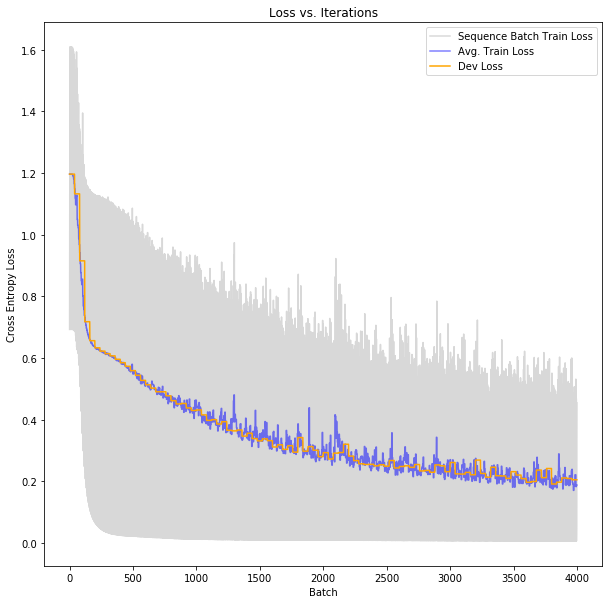

In [20]:
plt.figure(figsize=(10, 10))
plt.title("Loss vs. Iterations")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Batch')
plt.plot(loss_history,label='Sequence Batch Train Loss',color='grey',alpha=0.3)
plt.plot(wholeLoss_history,label='Avg. Train Loss',color='blue',alpha=0.5)
plt.plot(devLoss_history,label='Dev Loss',color='orange')
plt.legend()
plt.show()

### Inference

In [21]:
# print loss summary
aloss1=0
interloss=0
# Use data point
for seqLen in range(minSeqSize,maxSeqSize+1):
  X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
  interloss=infer(encoder,decoder,attention,X[seqLen],Y[seqLen])
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',interloss)
  aloss1+=interloss/(maxSeqSize+1-minSeqSize)

print('---')
aloss2=0
interloss=0
# Use data point
for seqLen in range(maxSeqSize+1,maxSeqSize+6):
  X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
  interloss=infer(encoder,decoder,attention,X[seqLen],Y[seqLen])
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',interloss)
  aloss2+=interloss/(5)
print()
print('aloss1:',np.round(aloss1,6))
print('aloss2:',np.round(aloss2,6))

Seq: 2 Size: 640 loss: 0.006781505420804024
Seq: 3 Size: 640 loss: 0.09650561213493347
Seq: 4 Size: 640 loss: 0.24197398126125336
Seq: 5 Size: 640 loss: 0.47921147346496584
---
Seq: 6 Size: 640 loss: 1.0093003908793132
Seq: 7 Size: 640 loss: 1.6724741799490792
Seq: 8 Size: 640 loss: 1.9665846824645996
Seq: 9 Size: 640 loss: 2.209872775607639
Seq: 10 Size: 640 loss: 2.397024154663086

aloss1: 0.206118
aloss2: 1.851051


In [22]:
#Print verbose level 1 detailed examples
for seqLen in range(minSeqSize,maxSeqSize+6):
  X,Y=makeData(seqLen,seqLen,2,1)
  print('Seq:',seqLen)
  print('\tloss:',infer(encoder,decoder,attention,X[seqLen],Y[seqLen],1))
  print('\n\n==============\n\n')

Seq: 2

===== PREDICTED: 0 =====

	- [0.         0.70881593]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.         0.70881593]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [0.         0.09216173]
	- [1. 0.]

--- ACTUAL: 1 ---

	- [0.         0.09216173]
	- [1. 0.]
	loss: 0.00706768361851573




Seq: 3

===== PREDICTED: 0 =====

	- [0.         0.37492886]
	- [0.         0.63655484]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.         0.37492886]
	- [0.         0.63655484]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [0.         0.13522436]
	- [0.         0.91253203]
	- [1. 0.]

--- ACTUAL: 1 ---

	- [0.         0.13522436]
	- [0.         0.91253203]
	- [1. 0.]
	loss: 0.02731916805108388




Seq: 4

===== PREDICTED: 0 =====

	- [0.         0.45698878]
	- [0.         0.49762738]
	- [0.        0.5424042]
	- [1. 0.]

--- ACTUAL: 0 ---

	- [0.         0.45698878]
	- [0.         0.49762738]
	- [0.        0.5424042]
	- [1. 0.]

===== PREDICTED: 1 =====

	- [0.         0.19463399]
	- [0.        0.6254916]
	- [0.     